# Generative Deep Learning - Exploration

This is a notebook containing my exploration into the field of generative deep learning.

## Introduction

The field of generative deep learning has always fascinated me (ever since I have seen the first [Google Deep Dream](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) examples, and the work of [Mario Klingemann](http://quasimondo.com/)), and saw an opportunity to deep dive into it while going into Semester 04 at CODE University. It developed into the first steps of research into an interactive installation done with artist [Diane Drubay](www.dianedrubay.com)

This being an ongoing project (outside of the semester scope), the final result will be available in a later period of time.

## Content 
1. [Deep learning](#Deep-learning)<br>
    1.1 [Load the cifar10 data](#Load-the-cifar10-data)<br>
    1.2 [Building](#Building-the-Model)<br>
    1.3 [Compiling](#Compiling-the-Model)<br>
    1.4 [Training](#Training-the-Model)<br>
    1.5 [Evaluating](#Evaluating-the-Model)<br>
    1.6 [Improving](#Improving-the-Model)<br>
    <br>
2. [Autoencoder](#Autoencoder)<br>
    2.1 [Load the data](#Load-the-data)<br>
    2.2 [Neural Network structure](#Define-the-structure-of-the-neural-network)<br>
    2.3 [Creating the Encoder](#Encoder)<br>
    2.4 [Creating the Decoder](#Decoder)<br>
    2.5 [Joining the Encoder to the Decoder](#Joining-the-Encoder-to-the-Decoder)<br>
    2.6 [Compilation](#Compilation)<br>
    2.7 [Training](#Training)<br>
    2.8 [Analysing](#Analysing-the-results)<br>
    <br>
3. [Variational Autoencoder](#Variational-Autoencoder)<br>
    3.1 [VAE Encoder](#VAE-Encoder)<br>
    3.2 [VAE Decoder](#VAE-Decoder)<br>
    <br>
4. [StyleGAN2 from Nvidia](#StyleGAN2)<br>
    4.1 [Exploration](#Exploration)<br>
    4.2 [Dataset](#Dataset)<br>
    4.3 [Training](#Training)<br>
    4.4 [Metrics](#Metrics)<br>
    4.5 [Generating images](#Generating-images)<br>

# Imports

These imports are valid for the whole notebook. If other modules are needed, they will be available for import in their corresponding section.

In [1]:
import numpy as np

from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K#Variational-Autoencoder
from keras.utils import plot_model
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt


# we have to use the experimental features in order to avoid a memory overflow of the GPU
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Using TensorFlow backend.


# Deep-learning

This is the first real step into the direction of neural networks using keras. It can be considered as a warm-up.

## Load the cifar10 data

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 imagthees. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

It is noteworthy to tell that there are no <i>rows</i> or <i>columns</i> in this dataset, it's a <i>tensor</i> with four dimensions.

x_train, y_train are numpys arrays containing the image data <i>(32 x 32 px - 3 channel RGB colors)</i>

x_test, y_test are numpys arrays containing the integer labels in the range 0 to 9 for the class of each image.

In [2]:
num_classes = 10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

A quick confirmation that the data shape is as expected to be

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Showing the first 9 images of the dataset

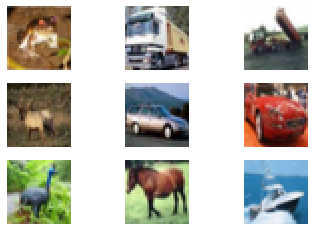

In [5]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.show()

Image data are integers between 255 and 0 - for the neural network we need a data range from -1 to 1

In [6]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

The integer labeling of the images needs to be changed into one-hot-encoded vectors. If the class integer label of an image is <i>i</i>, then its one-hot encoding is a vector of length 10 (num_classes) that has 0s in all but the <i>i</i>th element which is 1. The new shapes of y_train and y_test are therefore (50000, 10) and (10000, 10)

In [7]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Building the Model

In Keras, there are two ways to define the structre of the neural network: a Sequential model or using the Functional API.

The Sequential model is used to create quickly a linear stack of layers. But we need networks with layers being able to pass data to multiple separate layers beneath it, or inversely, that a layer receives input from multiple layers above it.

Therefore the Functional API of Keras is being used to build the model.
We are using three different types of layer: <b>Input, Flatten, Dense</b>

The <b>Input</b> layer which is basically our entry point into the network. The network is being told the shape of each data element to expect as a tuple (32, 32, 3)

The <b>Flatten</b> layer which flattens our data into a vector of length 3072 (32 x 32 x 3). This is needed as the subsequent layer needs a flat input rather than a multidimensional array.

The <b>Dense</b> layer which is the most fundamental layer in any neural network. It contains a certain number of units densely connected by a single connection carrying a weight. The output from a given unit is the weighted sum of the input it receives from the previous layer, passed through an activation function ('relu') before being sent to the next layer. This activation function is critical to ensure the neural network can learn complex functions.


### Activation functions

An Activation function is a critical part of a neural network, ensuring the learning of complex functions. It is used to determine the output of the node, and is also known as Transfer Function.

- The <i>ReLU</i> activation function is defined to be zero if the input is negative and is otherwise equal to the input.
- The <i>LeakyReLU</i> activation function is almost the same as the ReLU, but returns a proportional negative number if the input is less than zero
- The <i>sigmoid</i> activation is useful for binary classification problems with one output unit or multilabel classification problems
- the <i>softmax</i> activation if one needs the total sum of the output from the layer to equal 1 (multiclass classification problems where each observation only belongs to exactly one class)

Right beneath is a visual indicator of the various types of activation functions

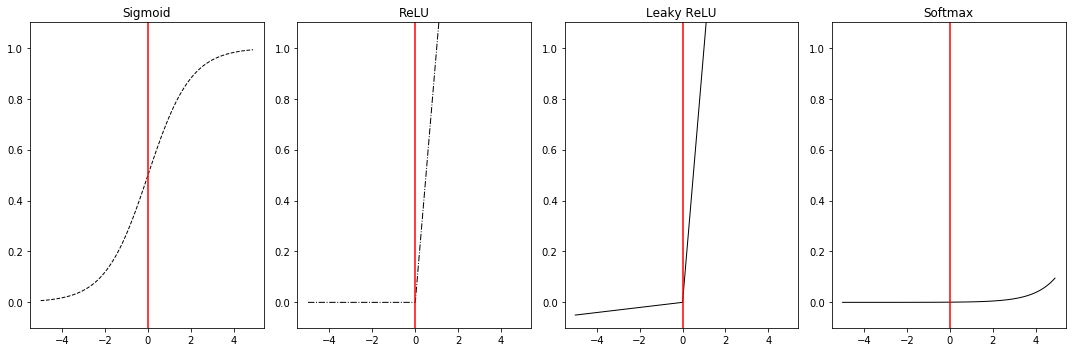

In [8]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x):
    return np.where(x > 0, x, x * 0.01)

def plot_zero_line(ax):
    return axes[ax].plot(np.zeros(len(x)), x, color='r')

x = np.arange(-5.0, 5.0, 0.1)

fig,axes=plt.subplots(nrows=1, ncols=4,figsize=(15,5))

axes[0].plot(x, sigmoid(x), color='k', lw=1, ls='--')
plot_zero_line(0)
axes[0].set_title('Sigmoid')
axes[1].plot(x, relu(x), color='k', lw=1, linestyle='-.')
plot_zero_line(1)
axes[1].set_title('ReLU')
axes[2].plot(x, leaky_relu(x), color='k', lw=1)
plot_zero_line(2)
axes[2].set_title('Leaky ReLU')
axes[3].plot(x, softmax(x), color='k', lw=1, ls='-')
plot_zero_line(3)
axes[3].set_title('Softmax')

for ax in axes:
    ax.set_ylim(-0.1, 1.1)
fig.tight_layout()
plt.show()

This is our Model

In [9]:
input_layer = Input(shape=(32, 32, 3))

x = Flatten()(input_layer)

x = Dense(units=200, activation='relu')(x)
x = Dense(units=150, activation='relu')(x)

output_layer = Dense(units=10, activation='softmax')(x)

model = Model(input_layer, output_layer)

## Compiling the Model

Here we compile the model with an optimizer (Adam) and a loss function.

The most commonly used loss functions are <i>mean squared loss</i> used to solve a regression problem (the output is continuous). If one is working on a classification problem where each observation only belongs to one class, use the <i>categorical cross-entropy</i>. And at last, if one is working on a binary classification problem with one output unit or a multilabel problem where each observation can belong to multiple classes, use <i>binary cross-entropy</i>


In [10]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Training the Model

In [11]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)


Epoch 1/10
50000/50000 [==============================] - 5s 90us/step - loss: 1.8528 - accuracy: 0.3341
Epoch 2/10
50000/50000 [==============================] - 4s 85us/step - loss: 1.6652 - accuracy: 0.4048
Epoch 3/10
50000/50000 [==============================] - 4s 87us/step - loss: 1.5916 - accuracy: 0.4329
Epoch 4/10
50000/50000 [==============================] - 4s 88us/step - loss: 1.5431 - accuracy: 0.4526
Epoch 5/10
50000/50000 [==============================] - 4s 88us/step - loss: 1.4997 - accuracy: 0.4676
Epoch 6/10
50000/50000 [==============================] - 4s 87us/step - loss: 1.4663 - accuracy: 0.4796
Epoch 7/10
50000/50000 [==============================] - 4s 88us/step - loss: 1.4376 - accuracy: 0.4908
Epoch 8/10
50000/50000 [==============================] - 4s 88us/step - loss: 1.4113 - accuracy: 0.4978
Epoch 9/10
50000/50000 [==============================] - 4s 87us/step - loss: 1.3862 - accuracy: 0.5085
Epoch 10/10
50000/50000 [=============================

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               614600    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1510      
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


## Evaluating the Model

The output of this method are categorical cross-entropy and accuracy on the test data (meaning the Model has never seen this data). The Model accuracy is around the same as with the training data.

In [13]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 0s 49us/step


[1.402125793647766, 0.5049999952316284]

Below is a display of 10 randomly selected images with their predictions. We're on par with the accuracy, meaning that around 50% of the images are correctly labelled.

In [14]:
def random_images_predictions():
    CLASSES = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
    predictions = model.predict(x_test)
    predictions_single = CLASSES[np.argmax(predictions, axis=-1)]
    actuals_single = CLASSES[np.argmax(y_test, axis=-1)]

    num_to_show = 10
    indices = np.random.choice(range(len(x_test)), num_to_show)

    fig = plt.figure(figsize=(15, 3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, idx in enumerate(indices):
        img = x_test[idx]
        ax = fig.add_subplot(1, num_to_show, i + 1)
        ax.axis('off')
        if (predictions_single[idx] == actuals_single[idx]):
            color = 'g'
        else:
            color = 'r'
        ax.text(0.5, -0.35, 'pred = ' + str(predictions_single[idx]), fontsize = 10, ha='center', transform=ax.transAxes, color=color)
        ax.text(0.5, -0.7, 'act = ' + str(actuals_single[idx]), fontsize = 10, ha='center', transform=ax.transAxes, color=color)
        ax.imshow(img)

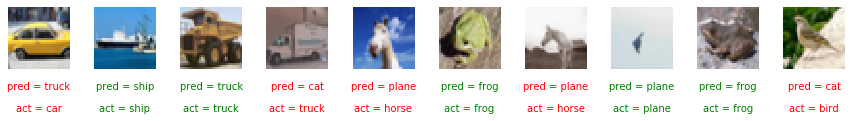

In [15]:
random_images_predictions()

## Improving the Model

The spatial structure of the pictures is not taken into account, hence the poor result. To get better result we can use <i>convolutional</i> layers.

### Convolutional layers
A convolution is the simple application of a filter to an input that results in an activation. Repeated application of the same filter to an input results in a map of activations called a feature map, indicating the locations and strength of a detected feature in an input, such as an image.


### Batch normalization

We want to ensure that the weights of the network remain within a reasonable range of values. If not, we will face the <i>exploding gradient</i> problem. One solution to that is to use a Batch Normalization layer. It calculates the mean and standard deviation of each of its input channel across the batch and normalizes by subtracting the mean and dividing by the standard deviation. We place them after dense or convolutional layers to normalize the output of those layers.

### Dropout layers

An additional step to avoid <i>overfitting</i> is to use dropout layers. A dropout layer chooses a random set of units from the preceding layers, and sets their output to zero. This ensures that our Model will be able to generalize on unseen data.

### The new Model

In [16]:
input_layer = Input((32, 32, 3))
x = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=0.5)(x)

x = Dense(num_classes)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

In [17]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [18]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)

Epoch 1/10
50000/50000 [==============================] - 13s 267us/step - loss: 1.5727 - accuracy: 0.4487
Epoch 2/10
50000/50000 [==============================] - 11s 223us/step - loss: 1.1501 - accuracy: 0.5952
Epoch 3/10
50000/50000 [==============================] - 11s 223us/step - loss: 0.9924 - accuracy: 0.6544
Epoch 4/10
50000/50000 [==============================] - 11s 223us/step - loss: 0.9055 - accuracy: 0.6870
Epoch 5/10
50000/50000 [==============================] - 11s 223us/step - loss: 0.8432 - accuracy: 0.7084
Epoch 6/10
50000/50000 [==============================] - 11s 224us/step - loss: 0.7948 - accuracy: 0.7223
Epoch 7/10
50000/50000 [==============================] - 11s 224us/step - loss: 0.7547 - accuracy: 0.7375
Epoch 8/10
50000/50000 [==============================] - 11s 223us/step - loss: 0.7129 - accuracy: 0.7516
Epoch 9/10
50000/50000 [==============================] - 11s 227us/step - loss: 0.6768 - accuracy: 0.7639
Epoch 10/10
50000/50000 [============

In [19]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 32)        0   

In [20]:
model.evaluate(x_test, y_test, batch_size=1000)

10000/10000 [==============================] - 1s 65us/step


[0.8203020513057708, 0.7200000286102295]

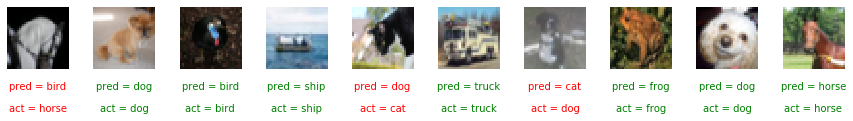

In [21]:
random_images_predictions()

Using the convolutional layers greatly improved the accuracy of the Model. We went from around 50% to 72% of accuracy.

# Autoencoder

## Load the data

In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

## Define the structure of the neural network

In [23]:
input_dim = (28, 28, 1)
encoder_conv_filters = [32,64,64,64]
encoder_conv_kernel_size = [3,3,3,3]
encoder_conv_strides = [1,2,2,1]
decoder_conv_t_filters = [64,64,32,1]
decoder_conv_t_kernel_size = [3,3,3,3]
decoder_conv_t_strides = [1,2,2,1]
z_dim = 2

use_batch_norm = False
use_dropout = False

n_layers_encoder = len(encoder_conv_filters)
n_layers_decoder = len(decoder_conv_t_filters)

## Encoder

In [24]:
encoder_input = Input(shape = input_dim, name = 'encoder_input')

In [25]:
x = encoder_input

for i in range(n_layers_encoder):
    conv_layer = Conv2D(
        filters = encoder_conv_filters[i],
        kernel_size = encoder_conv_kernel_size[i],
        strides = encoder_conv_strides[i],
        padding = 'same',
        name = 'encoder_conv_' + str(i))
    
    x = conv_layer(x) # Stack the convolutional layers on top of each other
    x = LeakyReLU()(x)
    
    if use_batch_norm:
        x = BatchNormalization()(x)
    if use_dropout:
        x = Dropout(rate = 0.25)(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x) # Flatten the last conv. layer to a vector

In [26]:
encoder_output = Dense(z_dim, name = 'encoder_output')(x)

In [27]:
encoder = Model(encoder_input, encoder_output)

In [28]:
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 64)          0   

## Decoder

In [29]:
decoder_input = Input(shape = (z_dim, ), name = 'decoder_input')

In [30]:
x = Dense(np.prod(shape_before_flattening))(decoder_input)

In [31]:
x = Reshape(shape_before_flattening)(x)

In [32]:
for i in range(n_layers_decoder):
    conv_t_layer = Conv2DTranspose(
        filters = decoder_conv_t_filters[i],
        kernel_size = decoder_conv_t_kernel_size[i],
        strides = decoder_conv_t_strides[i],
        padding = 'same',
        name = 'decoder_conv_t_' + str(i))
    
    x = conv_t_layer(x) # Stack the conv. transpose layers on top of each other
    
    if i < n_layers_decoder - 1:
        x = LeakyReLU()(x)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        if use_dropout:
            x = Dropout(rate = 0.25)(x)
    else:
        x = Activation('sigmoid')(x)

In [33]:
decoder_output = x

In [34]:
decoder = Model(decoder_input, decoder_output)

In [35]:
decoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 64)        0   

## Joining the Encoder to the Decoder

In [36]:
model_input = encoder_input # The input to the autoencoder is the same as the input to the encoder
model_output = decoder(encoder_output) # The output from the autoencoder is the output from the encoder passed through the decoder

In [37]:
model = Model(model_input, model_output)

## Compilation

In [38]:
learning_rate = 0.0005
batch_size = 32
initial_epoch = 0

In [39]:
optimizer = Adam(lr = learning_rate)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1, 2, 3])

model.compile(optimizer = optimizer, loss = r_loss)

## Training

In [41]:
model.fit(x = x_train,
          y = x_train,
          batch_size = batch_size,
          shuffle = True,
          epochs = 200,
          initial_epoch = initial_epoch)

Epoch 1/200
60000/60000 [==============================] - 11s 188us/step - loss: 0.0425
Epoch 2/200
60000/60000 [==============================] - 12s 194us/step - loss: 0.0420
Epoch 3/200
60000/60000 [==============================] - 12s 195us/step - loss: 0.0416
Epoch 4/200
60000/60000 [==============================] - 11s 191us/step - loss: 0.0412
Epoch 5/200
60000/60000 [==============================] - 11s 188us/step - loss: 0.0409
Epoch 6/200
60000/60000 [==============================] - 11s 187us/step - loss: 0.0407
Epoch 7/200
60000/60000 [==============================] - 11s 187us/step - loss: 0.0405
Epoch 8/200
60000/60000 [==============================] - 11s 188us/step - loss: 0.0403
Epoch 9/200
60000/60000 [==============================] - 11s 187us/step - loss: 0.0401
Epoch 10/200
60000/60000 [==============================] - 11s 187us/step - loss: 0.0400
Epoch 11/200
60000/60000 [==============================] - 11s 187us/step - loss: 0.0398
Epoch 12/200
60000/

60000/60000 [==============================] - 11s 190us/step - loss: 0.0366
Epoch 92/200
60000/60000 [==============================] - 12s 192us/step - loss: 0.0366
Epoch 93/200
60000/60000 [==============================] - 11s 191us/step - loss: 0.0366
Epoch 94/200
60000/60000 [==============================] - 11s 192us/step - loss: 0.0366
Epoch 95/200
60000/60000 [==============================] - 12s 194us/step - loss: 0.0366
Epoch 96/200
60000/60000 [==============================] - 12s 199us/step - loss: 0.0366
Epoch 97/200
60000/60000 [==============================] - 12s 203us/step - loss: 0.0365
Epoch 98/200
60000/60000 [==============================] - 12s 204us/step - loss: 0.0365
Epoch 99/200
60000/60000 [==============================] - 12s 192us/step - loss: 0.0365
Epoch 100/200
60000/60000 [==============================] - 12s 196us/step - loss: 0.0365
Epoch 101/200
60000/60000 [==============================] - 11s 191us/step - loss: 0.0365
Epoch 102/200
60000/6

60000/60000 [==============================] - 11s 191us/step - loss: 0.0356
Epoch 181/200
60000/60000 [==============================] - 11s 190us/step - loss: 0.0356
Epoch 182/200
60000/60000 [==============================] - 11s 190us/step - loss: 0.0356
Epoch 183/200
60000/60000 [==============================] - 11s 191us/step - loss: 0.0356
Epoch 184/200
60000/60000 [==============================] - 11s 190us/step - loss: 0.0356
Epoch 185/200
60000/60000 [==============================] - 11s 191us/step - loss: 0.0355
Epoch 186/200
60000/60000 [==============================] - 11s 190us/step - loss: 0.0355
Epoch 187/200
60000/60000 [==============================] - 11s 190us/step - loss: 0.0356
Epoch 188/200
60000/60000 [==============================] - 11s 189us/step - loss: 0.0355
Epoch 189/200
60000/60000 [==============================] - 11s 189us/step - loss: 0.0355
Epoch 190/200
60000/60000 [==============================] - 11s 189us/step - loss: 0.0355
Epoch 191/200

## Analysing the results

In [42]:
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

### Reconstruction of the original images

In [43]:
def reconstruct_original_images():
    n_to_show = 10
    example_idx = np.random.choice(range(len(x_test)), n_to_show)
    example_images = x_test[example_idx]

    z_points = encoder.predict(example_images)

    reconst_images = decoder.predict(z_points)

    fig = plt.figure(figsize = (15, 3))
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

    for i in range(n_to_show):
        img = example_images[i].squeeze() # Remove single-dimensional entries from the shape of an array.
        ax = fig.add_subplot(2, n_to_show, i + 1)
        ax.axis('off')
        ax.text(0.5, -0.35, str(np.round(z_points[i], 1)), fontsize = 10, ha = 'center', transform = ax.transAxes)
        ax.imshow(img, cmap = 'gray_r')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        ax = fig.add_subplot(2, n_to_show, i + n_to_show + 1)
        ax.axis('off')
        ax.imshow(img, cmap = 'gray_r')

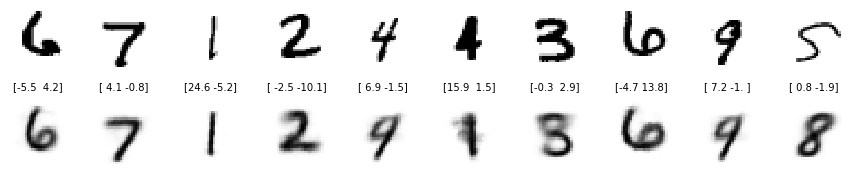

In [44]:
reconstruct_original_images()

### Latent Space

In [45]:
def latent_space():
    n_to_show = 5000
    grid_size = 15
    figsize = 12

    example_idx = np.random.choice(range(len(x_test)), n_to_show)
    example_images = x_test[example_idx]
    example_labels = y_test[example_idx]

    z_points = encoder.predict(example_images)

    min_x = min(z_points[:, 0])
    max_x = max(z_points[:, 0])
    min_y = min(z_points[:, 1])
    max_y = max(z_points[:, 1])

    plt.figure(figsize = (figsize, figsize))
    plt.scatter(z_points[:, 0] , z_points[:, 1], c = 'black', alpha = 0.5, s = 2)
    plt.show()

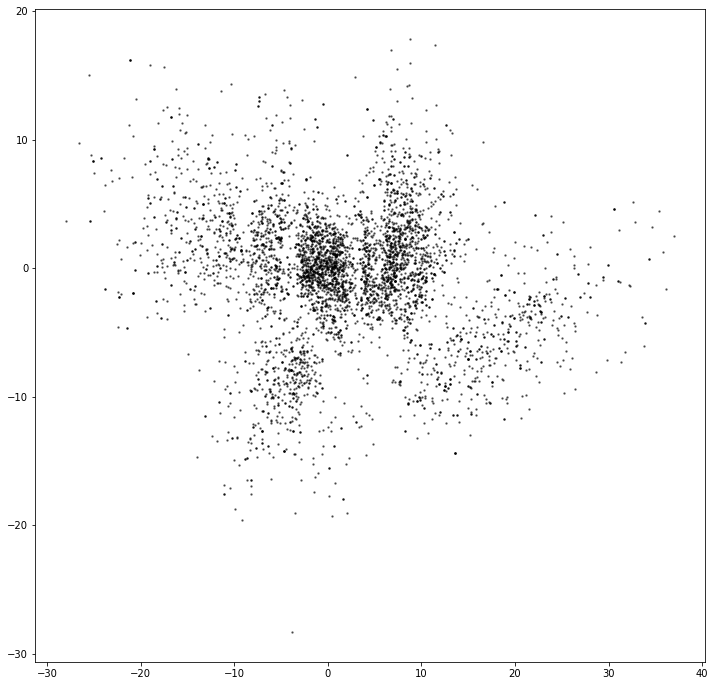

In [46]:
latent_space()

### Random sampling of the Latent Space

In [47]:
def random_sampling_latent_space():
    n_to_show = 5000
    grid_size = 15
    figsize = 15
    
    example_idx = np.random.choice(range(len(x_test)), n_to_show)
    example_images = x_test[example_idx]
    example_labels = y_test[example_idx]
    
    z_points = encoder.predict(example_images)
    plt.figure(figsize = (figsize, figsize))
    plt.scatter(z_points[:, 0], z_points[:, 1], c = 'black', alpha = 0.5, s = 2)

    grid_size = 10
    grid_depth = 3
    figsize = 15
    
    min_x = min(z_points[:, 0])
    max_x = max(z_points[:, 0])
    min_y = min(z_points[:, 1])
    max_y = max(z_points[:, 1])

    x = np.random.uniform(min_x, max_x, size = grid_size * grid_depth)
    y = np.random.uniform(min_y, max_y, size = grid_size * grid_depth)
    z_grid = np.array(list(zip(x, y)))
    reconst = decoder.predict(z_grid)

    plt.scatter(z_grid[:, 0], z_grid[:, 1], c = 'red', alpha = 1, s = 20)
    plt.show()

    fig = plt.figure(figsize = (figsize, grid_depth))
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

    for i in range(grid_size * grid_depth):
        ax = fig.add_subplot(grid_depth, grid_size, i + 1)
        ax.axis('off')
        ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize = 10, ha = 'center', transform = ax.transAxes)

        ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

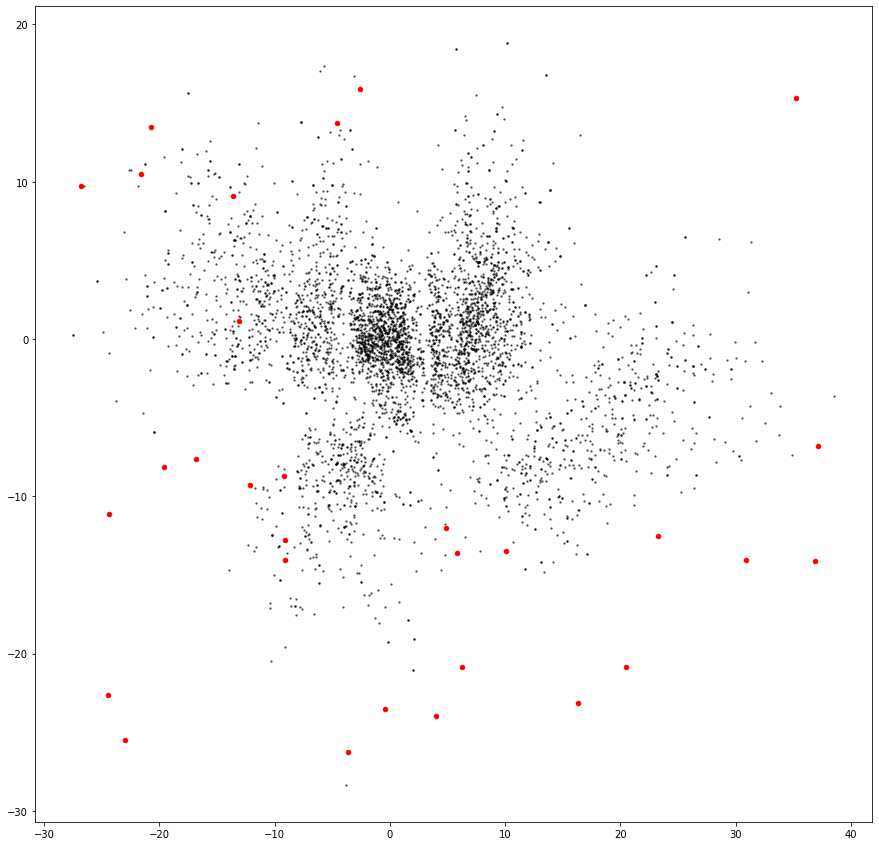

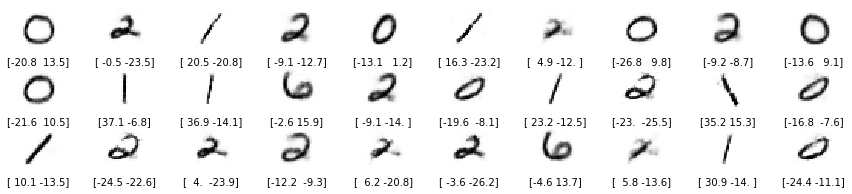

In [48]:
random_sampling_latent_space()

### Latent space sorted by digits

In [49]:
def latent_space_digits_sorted():
    n_to_show = 5000
    grid_size = 15
    figsize = 12

    example_idx = np.random.choice(range(len(x_test)), n_to_show)
    example_images = x_test[example_idx]
    example_labels = y_test[example_idx]

    z_points = encoder.predict(example_images)

    plt.figure(figsize = (figsize, figsize))
    plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap ='rainbow' , c = example_labels, alpha = 0.5, s = 2)
    plt.colorbar()
    plt.show()

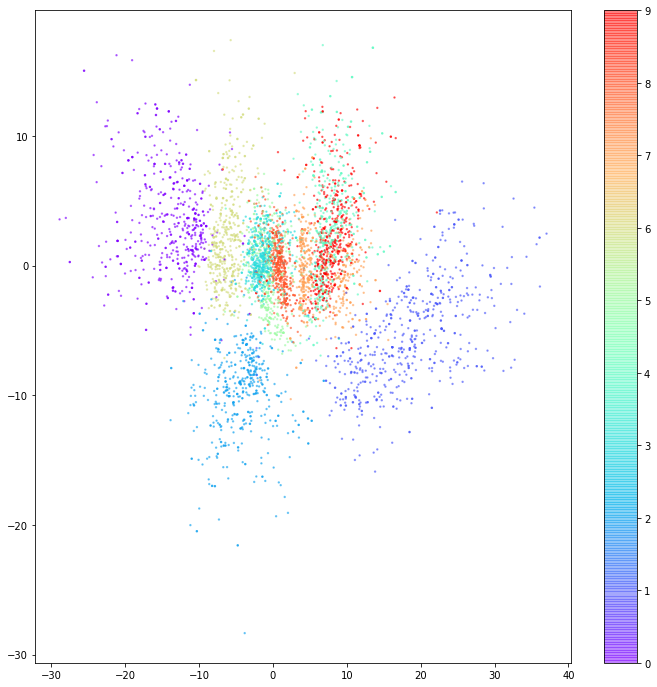

In [50]:
latent_space_digits_sorted()

In [51]:
def latent_space_digits():
    n_to_show = 5000
    grid_size = 20
    figsize = 8

    example_idx = np.random.choice(range(len(x_test)), n_to_show)
    example_images = x_test[example_idx]
    example_labels = y_test[example_idx]

    z_points = encoder.predict(example_images)

    plt.figure(figsize=(5, 5))
    plt.scatter(z_points[:, 0], z_points[:, 1] , cmap = 'rainbow' , c = example_labels, alpha = 0.5, s = 2)
    plt.colorbar()

    # x = norm.ppf(np.linspace(0.05, 0.95, 10))
    # y = norm.ppf(np.linspace(0.05, 0.95, 10))
    x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
    y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
    xv, yv = np.meshgrid(x, y)
    xv = xv.flatten()
    yv = yv.flatten()
    z_grid = np.array(list(zip(xv, yv)))

    reconst = decoder.predict(z_grid)

    plt.scatter(z_grid[:, 0], z_grid[:, 1], c = 'black', alpha = 1, s = 5)#, cmap='rainbow' , c= example_labels

    plt.show()

    fig = plt.figure(figsize = (figsize, figsize))
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
    for i in range(grid_size ** 2):
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.axis('off')
        ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

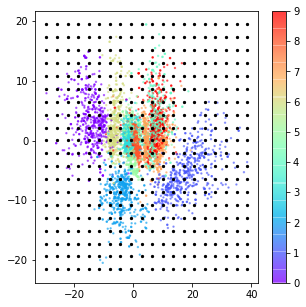

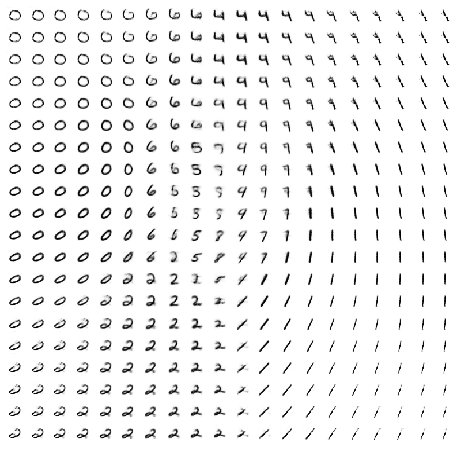

In [52]:
latent_space_digits()

# Variational Autoencoder

In an autoencoder, each image is mapped directly to one point in the latent space. 

In a variational autoencoder, each image is instead mapped to a multivariate normal distribution around a point in latent space.

To summarize, the encoder will take each input image and encode it to two vectors, <b>mu</b> and <b>log_var</b> which together define a multivariate normal distribution in the latent space.

<b>mu</b> - the mean point of the distribution
<br><b>log_var</b> - the logarithm of the variance of each dimension

To encode an image into a specific point <b>z</b> in the latent space, we can sample from this distribution, using the following equation:

z = mu + sigma * epsilon

sigma = exp(log_var / 2)

## VAE Encoder

In [53]:
x = encoder_input

for i in range(n_layers_encoder):
    conv_layer = Conv2D(
        filters = encoder_conv_filters[i],
        kernel_size = encoder_conv_kernel_size[i],
        strides = encoder_conv_strides[i],
        padding = 'same',
        name = 'encoder_conv_' + str(i))
    
    x = conv_layer(x) # Stack the convolutional layers on top of each other
    
    if use_batch_norm:
        x = BatchNormalization()(x)
        
    x = LeakyReLU()(x)
    if use_dropout:
        x = Dropout(rate = 0.25)(x)

shape_before_flattening = K.int_shape(x)[1:]

x = Flatten()(x) # Flatten the last conv. layer to a vector

In [54]:
mu = Dense(z_dim, name = 'mu')(x)
log_var = Dense(z_dim, name = 'log_var')(x)

In [55]:
encoder_mu_log_var = Model(encoder_input, (mu, log_var))

In [56]:
def sampling(args):
    mu, log_vars = args
    epsilon = K.random_normal(shape = K.shape(mu), mean = 0., stddev = 1.)
    return mu * K.exp(log_var / 2) * epsilon

In [57]:
encoder_output = Lambda(sampling, name = 'encoder_output')([mu, log_var])

In [58]:
encoder = Model(encoder_input, encoder_output)

In [59]:
encoder.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu_13[0][0]             
____________________________________________________________________________________________

## VAE Decoder

The decoder is identical to the Autoencoder, the only thing needed to be changed is the loss function.

The loss function in the Autoencoder is a RMSE function. It's the same in a VAE but we need an additional component: the <i>Kullback-Leibler(KL) divergence.</i>

KL divergence is a way of measuring how much one probability distribution differs from another. In a VAE we want to measure how different our normal distribution with parameters <b>mu</b> and <b>log_var</b> is from the standard normal distribution.

The KL divergence term penalizes the network for encoding observations to <b>mu</b> and <b>log_var</b> variables that differ significantly from the parameters of a standard normal distribution, namely <b>mu = 0</b> and <b>log_var = 0</b>

In [60]:
decoder_input = Input(shape = (z_dim, ), name = 'decoder_input')

x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)

for i in range(n_layers_decoder):
    conv_t_layer = Conv2DTranspose(
        filters = decoder_conv_t_filters[i],
        kernel_size = decoder_conv_t_kernel_size[i],
        strides = decoder_conv_t_strides[i],
        padding = 'same',
        name = 'decoder_conv_t_' + str(i))
    
    x = conv_t_layer(x) # Stack the conv. transpose layers on top of each other
    
    if i < n_layers_decoder - 1:
        x = LeakyReLU()(x)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        if use_dropout:
            x = Dropout(rate = 0.25)(x)
    else:
        x = Activation('sigmoid')(x)

decoder_output = x

decoder = Model(decoder_input, decoder_output)
model = Model(model_input, model_output)

In [61]:
learning_rate = 0.0005
batch_size = 32
initial_epoch = 0
r_loss_factor = 1000

In [62]:
optimizer = Adam(lr = learning_rate)

def vae_r_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1, 2, 3])
    return r_loss_factor * r_loss

def vae_kl_loss(y_true, y_pred):
    kl_loss = -0.5 * K.sum(1 * log_var - K.square(mu) - K.exp(log_var), axis = 1)
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return r_loss + kl_loss

model.compile(optimizer = optimizer, loss = vae_loss, metrics = [vae_r_loss, vae_kl_loss])

In [64]:
model.fit(x = x_train,
          y = x_train,
          batch_size = batch_size,
          shuffle = True,
          epochs = 200,
          initial_epoch = initial_epoch)

Epoch 1/200
60000/60000 [==============================] - 13s 215us/step - loss: 36.3785 - vae_r_loss: 35.3766 - vae_kl_loss: 1.0019
Epoch 2/200
60000/60000 [==============================] - 13s 215us/step - loss: 36.4151 - vae_r_loss: 35.4133 - vae_kl_loss: 1.0019
Epoch 3/200
60000/60000 [==============================] - 13s 214us/step - loss: 36.3787 - vae_r_loss: 35.3768 - vae_kl_loss: 1.0019
Epoch 4/200
60000/60000 [==============================] - 13s 213us/step - loss: 36.3546 - vae_r_loss: 35.3528 - vae_kl_loss: 1.0019
Epoch 5/200
60000/60000 [==============================] - 13s 213us/step - loss: 36.3224 - vae_r_loss: 35.3205 - vae_kl_loss: 1.0019
Epoch 6/200
60000/60000 [==============================] - 13s 213us/step - loss: 36.3669 - vae_r_loss: 35.3651 - vae_kl_loss: 1.0019
Epoch 7/200
60000/60000 [==============================] - 13s 214us/step - loss: 36.3546 - vae_r_loss: 35.3528 - vae_kl_loss: 1.0019
Epoch 8/200
60000/60000 [==============================] - 13s

60000/60000 [==============================] - 14s 231us/step - loss: 36.0471 - vae_r_loss: 35.0453 - vae_kl_loss: 1.0019
Epoch 62/200
60000/60000 [==============================] - 14s 230us/step - loss: 36.0434 - vae_r_loss: 35.0415 - vae_kl_loss: 1.0019
Epoch 63/200
60000/60000 [==============================] - 14s 230us/step - loss: 36.0155 - vae_r_loss: 35.0136 - vae_kl_loss: 1.0019
Epoch 64/200
60000/60000 [==============================] - 14s 230us/step - loss: 36.0248 - vae_r_loss: 35.0230 - vae_kl_loss: 1.0019
Epoch 65/200
60000/60000 [==============================] - 13s 214us/step - loss: 36.0213 - vae_r_loss: 35.0195 - vae_kl_loss: 1.0019
Epoch 66/200
60000/60000 [==============================] - 13s 215us/step - loss: 36.0201 - vae_r_loss: 35.0182 - vae_kl_loss: 1.0019
Epoch 67/200
60000/60000 [==============================] - 13s 214us/step - loss: 35.9882 - vae_r_loss: 34.9863 - vae_kl_loss: 1.0019
Epoch 68/200
60000/60000 [==============================] - 13s 221u

60000/60000 [==============================] - 13s 214us/step - loss: 35.7633 - vae_r_loss: 34.7614 - vae_kl_loss: 1.0019
Epoch 122/200
60000/60000 [==============================] - 13s 214us/step - loss: 35.7697 - vae_r_loss: 34.7679 - vae_kl_loss: 1.0019
Epoch 123/200
60000/60000 [==============================] - 13s 215us/step - loss: 35.7711 - vae_r_loss: 34.7693 - vae_kl_loss: 1.0019
Epoch 124/200
60000/60000 [==============================] - 13s 214us/step - loss: 35.7934 - vae_r_loss: 34.7915 - vae_kl_loss: 1.0019
Epoch 125/200
60000/60000 [==============================] - 13s 220us/step - loss: 35.7564 - vae_r_loss: 34.7545 - vae_kl_loss: 1.0019
Epoch 126/200
60000/60000 [==============================] - 13s 214us/step - loss: 35.7733 - vae_r_loss: 34.7715 - vae_kl_loss: 1.0019
Epoch 127/200
60000/60000 [==============================] - 13s 214us/step - loss: 35.7890 - vae_r_loss: 34.7871 - vae_kl_loss: 1.0019
Epoch 128/200
60000/60000 [==============================] - 1

60000/60000 [==============================] - 13s 217us/step - loss: 35.5890 - vae_r_loss: 34.5871 - vae_kl_loss: 1.0019s - loss: 35.6015 - vae_r_los - ETA: 5s - loss: 35.5644 - vae - ETA: 4s - loss: 35.5873 - vae_r_loss: 34.5855 - vae_kl_lo - ETA: 4s - loss: 35.5891 - v - ETA: 2s - loss: - ETA: 1s - loss: 35.5725
Epoch 177/200
60000/60000 [==============================] - 13s 214us/step - loss: 35.5905 - vae_r_loss: 34.5886 - vae_kl_loss: 1.0019s - loss: 35.67
Epoch 178/200
60000/60000 [==============================] - 13s 214us/step - loss: 35.6051 - vae_r_loss: 34.6032 - vae_kl_loss: 1.0019s - loss: 35.6063 -
Epoch 179/200
60000/60000 [==============================] - 13s 213us/step - loss: 35.6222 - vae_r_loss: 34.6203 - vae_kl_loss: 1.0019
Epoch 180/200
60000/60000 [==============================] - 13s 213us/step - loss: 35.5909 - vae_r_loss: 34.5890 - vae_kl_loss: 1.0019
Epoch 181/200
60000/60000 [==============================] - 13s 213us/step - loss: 35.5876 - vae_r_loss:

# StyleGAN2

## Exploration

This is an exploration of the waves model based on a [StyleGAN2 by Nvidia](https://github.com/skyflynil/stylegan2) modified for non-square images (amongst other things) 

We start by doing random trips to the latent space, to gather the existing image types.
Then we use a method inspired by: https://medium.com/@memoakten/deep-meditations-meaningful-exploration-of-ones-inner-self-576aab2f3894

Each random image is tied to its numpy array, allowing to create different 'keyframes'. These can be used to create spherical interpolations (or physical interpolations) between two points in latent space. This allows, further down the line, to create sequences through a video NLE (Non Linear Editor) - using those 'keyframes' as actual keyframes inside the software.

Why spherical? The general distribution is a hyperdimensional sphere.

Why physical? the spherical distribution gives us non-smooth interpolations, so the physical interpolation allows for a smoother travel path. This is still a work in progress.

## Dataset

The dataset consists of various sea landscape videos that have been cropped to a square format (1024x1024) and reduced to image sequences. It is then fed to the model. The dataset can be found here (3 Gb size!): [dataset](https://drive.google.com/open?id=1lusgQA4jvaf_GSWQft2erH0c6t_qvEzi) 

## Training

The training has been done on a mix of platforms. The initial heavy weight training has been done on the RunwayML platform as they offer a free training on StyleGAN2 for 3000 steps. Their model is a pre-trained model with a dataset made out of lanscape images - which is the closest to the results we want to obtain.

Once this training has been done, the resulting weight are being used on a Google Colab platform in order to further the training and use free GPU resources. Google Colab gives access to high performance GPUs for around 12hours with a blocking period of 8 hours.

The Google Colab Notebook can be found here: [Google Colab](https://colab.research.google.com/drive/1xYubx87KiyljnVfsKCd0hsxi6KKgNjhL)

## Metrics

The following part allows us to analyse the training. Unfortunately, due to the training time, and the fact that hyperparameters are not accessible in the frame of RunwayML, our optimisation possibilities are rather limited.

But there are some metrics included in the StyleGAN2 model. Here are some numbers that have been ran on the final state of the waves model (504.pkl).

- The first one is the <b>FID - or Fréchet Inception Distance (FID score)</b>. It is used to determine visual similarity between two datasets of images. The FID score for this model shows us the disparity between our dataset and 'reality' represented by the 'inception_v3' model. We can assume that the score would lower with an augmentation of training time. The current score is <b>23.1470</b>

- The second metric is the <b>PPL or Perceptual Path Length</b>. Meaning that it measures the difference between consecutive images when interpolating between two random inputs. The lower the value, the more perceptually smooth the latent space is. The current score is <b>71.5810</b>

- The last metric is Precision and Recall. Precision is the ability of a classification model to identify only the relevant data points. Recall is the ability of a model to find all the relevant cases within a dataset. The current scores are <b>precision 0.0172 and recall 0.2132</b>

All in all, we can conclude that our trained model is not even near to producing realistic images as we can see from the various metrics computed on the last training weight. In this specific case, we can wonder if these metrics are relevant as the final goal for this project is to create synthetised images. The optimisation through hyperparameter tuning and the further training of the model would be two solutions.

But it is still interesting to use various saved weights to generate images that have the same keyframe (and thus the same position in the latent space), but a different weight. This offers a diversity of generated images that is more relevant to artistic purpose than real-life similarity. It allows us to have a point of view on the efficiency of the training process as we can compare them, not only on a metrics level, but also a visual level.

## Generating images

In [70]:
import os
import pickle
import gdown
import numpy as np
from PIL import Image
import math
import tensorflow as tf

Fancy progress bar using tqdm

In [71]:
%%capture
from tqdm.notebook import tqdm
tqdm()

In [72]:
git_repo = 'https://github.com/skyflynil/stylegan2.git'
src_path = './stylegan2'

%cd src

if os.path.exists(src_path) and len(os.listdir(src_path)) != 0:
    pass
else:
    !git clone $git_repo

%cd $src_path

C:\Users\Anon\Desktop\CODE\Semester 04\ADVANCED MACHINE LEARNING\CODE-SE-15-Advanced-Machine-Learning\src
C:\Users\Anon\Desktop\CODE\Semester 04\ADVANCED MACHINE LEARNING\CODE-SE-15-Advanced-Machine-Learning\src\stylegan2


In [73]:
model_snapshot_path = '../model_snapshot/'
model_snapshot = 'network-snapshot-000504.pkl'
model_snapshot_gdrive_url = 'https://drive.google.com/uc?id=1-PeMmAWtNlurqDTgZ8mbHbjdIeUE2Ags'

if os.path.exists(os.path.join(model_snapshot_path, model_snapshot)):
    pass
else:
    print('Downloading model snapshot from GDrive')
    gdown.download(model_snapshot_gdrive_url, os.path.join(model_snapshot_path, model_snapshot), quiet=False)

In [74]:
import dnnlib
import dnnlib.tflib as tflib

tflib.init_tf()

In [75]:
with open(os.path.join(model_snapshot_path, model_snapshot), 'rb') as f:
    _G, _D, Gs = pickle.load(f)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


### Generating random images from latent space

- Generate random array of tensors
- Generate random images from the latent space with the random array
- Save images with corresponding numpy file
- Display grid with random images

In [76]:
def generate_random_array(latent_dim, n_samples):
    rand_ar = []
    for n in range(n_samples):
        x_input = np.random.randn(latent_dim)
        z_input = x_input.reshape(1, latent_dim)
        rand_ar.append(z_input)
    return rand_ar

In [77]:
def generate_random_images(num_of_imgs, random_array, result_dir):
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

    list_imgs = list(range(1, num_of_imgs))
    
    #sub_folder = os.path.join(result_dir, ''.join([s for s in model_num if s.isdigit()]))
    
    for i in tqdm(list_imgs):
        latent_input = random_array[i]
        images = Gs.run(latent_input, None, truncation_psi = 1, randomize_noise = False, output_transform = fmt)
    
        # Save image
        #os.makedirs(sub_folder, exist_ok=True)
        png_filename = os.path.join(result_dir, 'random_' + str(i) + '.png')
        npy_filename = os.path.join(result_dir, 'random_' + str(i) + '.npy')
        np.save(npy_filename, latent_input)
        Image.fromarray(images[0], 'RGB').save(png_filename)

In [78]:
output_dir_random = '../../output/results_random'
max_n_samples = 15

In [79]:
random_array = generate_random_array(512, max_n_samples)

generate_random_images(len(random_array), random_array, output_dir_random)

### Generating random image grid

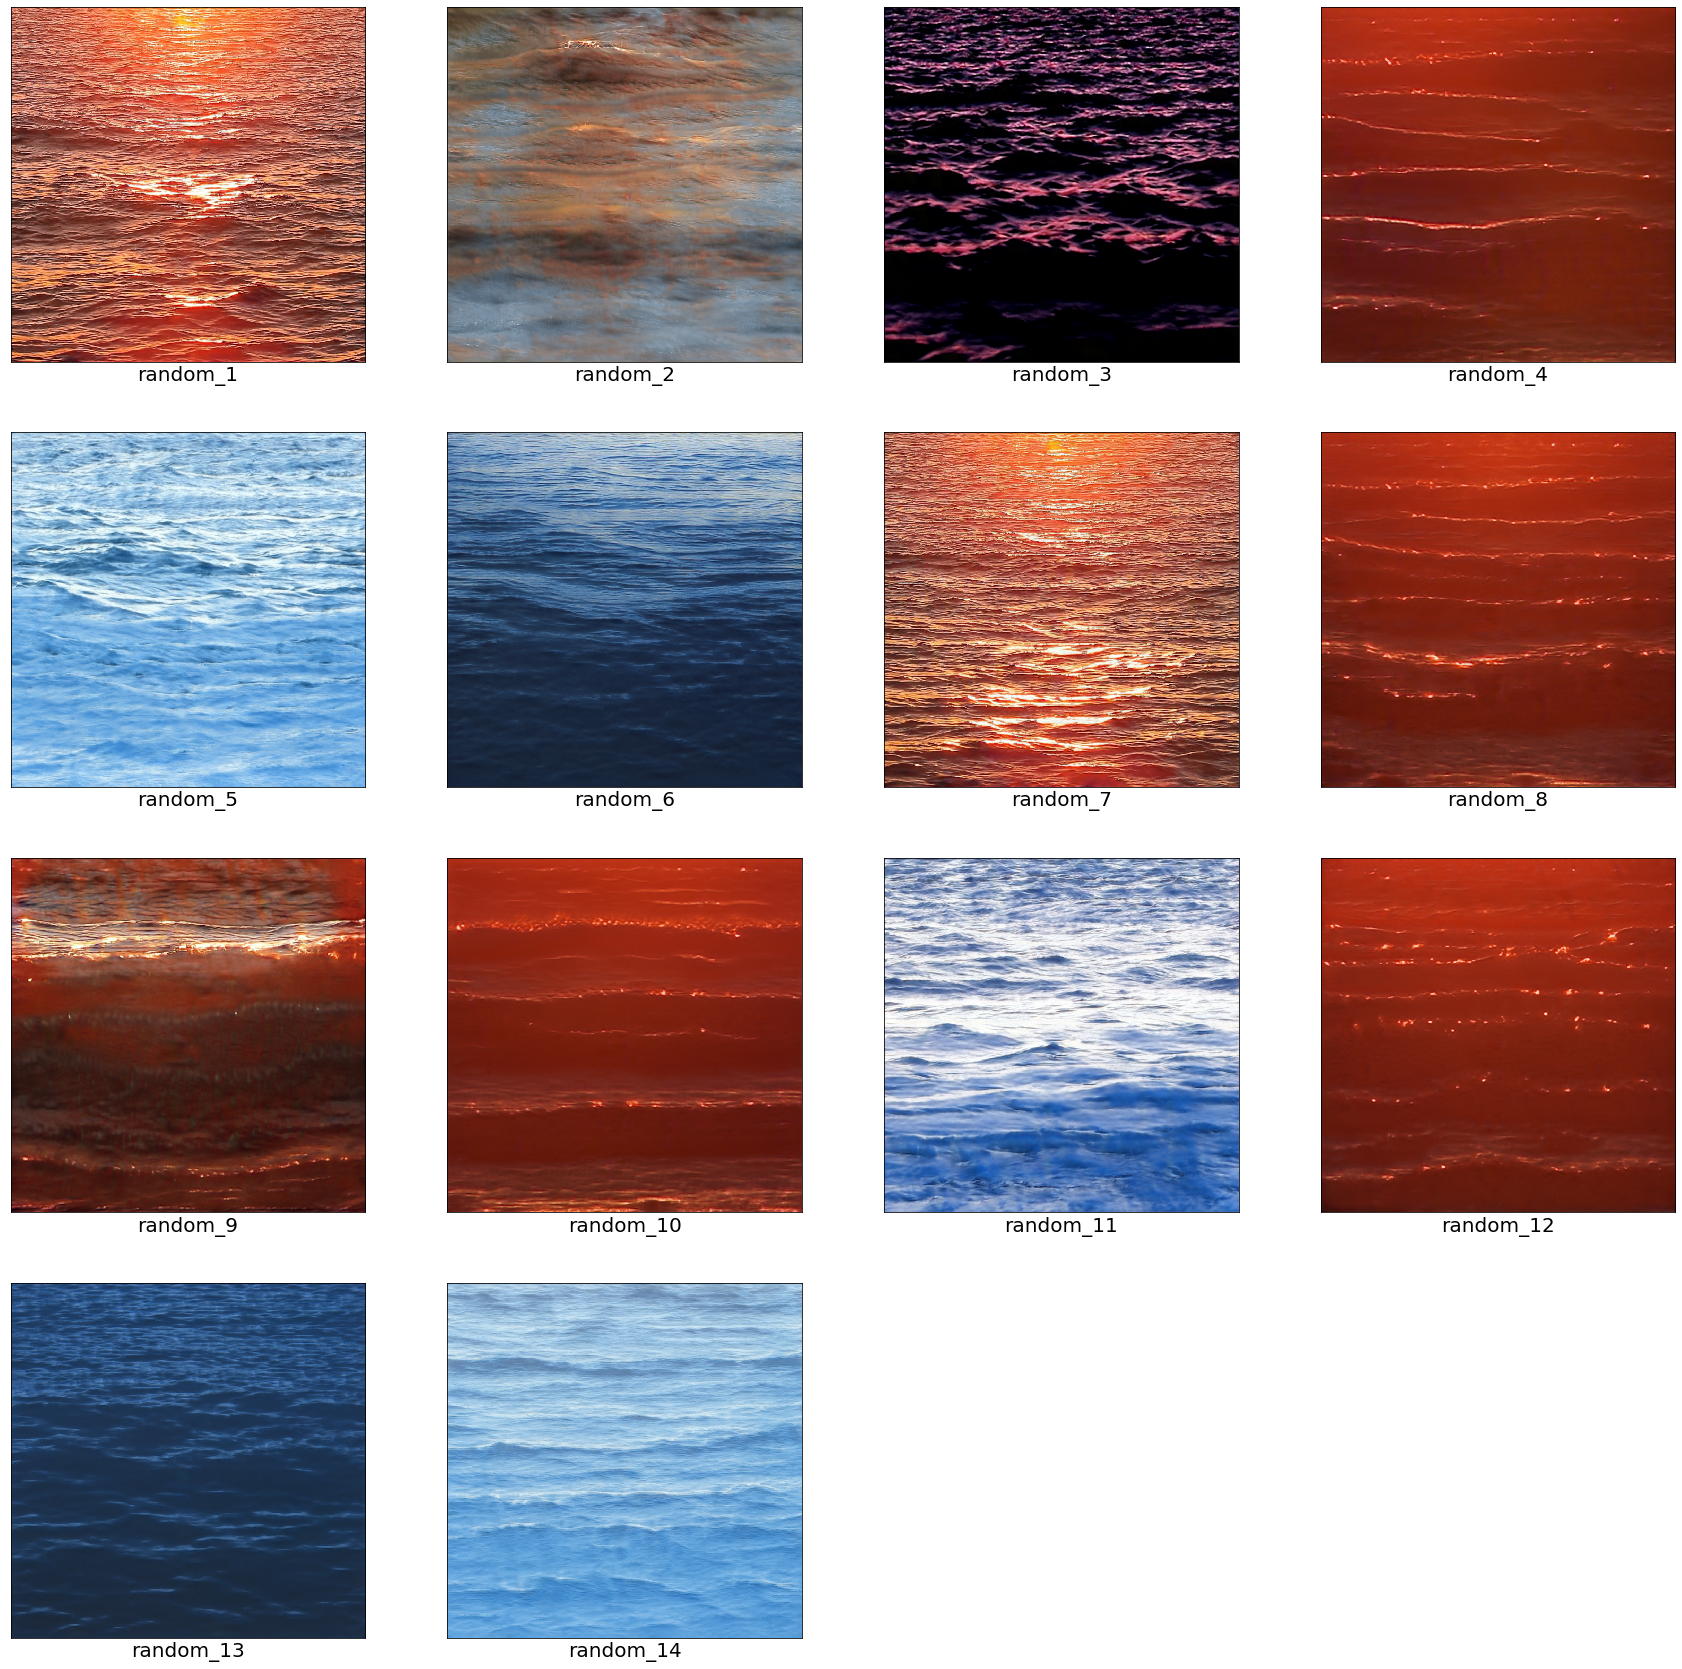

In [80]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob(output_dir_random + '/*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(30,30))
columns = 4
for i, image in enumerate(images):
    ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
    for item in ([ax.xaxis.label]) :
        item.set_fontsize(20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set(xlabel='random_' + str(i + 1))
    plt.imshow(image)

### Generating image sequence

- Generate two random latent tensors
- Spherical interpolation between these two tensors
- Output the individual images from the interpolation
- Render the latent space walk as video

In [81]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

In [82]:
def slerp(p0, p1, val):
    omega = np.arccos(np.clip(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)), -1, 1))
    so = math.sin(omega)
    if so == 0:
        return (1.0-val) * p0 + val * p1
    return math.sin((1.0-val)*omega)/so * p0 + math.sin(val*omega)/so * p1

In [83]:
def interpolate_points(p0, p1, n_steps=10):
    ratios = np.linspace(0, 1, n_steps)
    vectors = list()
    for ratio in ratios:
        v = slerp(p0, p1, ratio)
        vectors.append(v)
    return np.asarray(vectors)

In [84]:
def load_npy(*args):
    output = []
    for p in args:
        output.append(np.load(os.path.join(output_dir_random, 'random_' + str(p) + '.npy')))
    return np.vstack(output)

In [85]:
def next_path(path_pattern):
    i = 1

    # First do an exponential search
    while os.path.exists(path_pattern % i):
        i = i * 2

    # Result lies somewhere in the interval (i/2..i]
    # We call this interval (a..b] and narrow it down until a + 1 = b
    a, b = (i // 2, i)
    while a + 1 < b:
        c = (a + b) // 2 # interval midpoint
        a, b = (c, b) if os.path.exists(path_pattern % c) else (a, c)

    return path_pattern % b

In [86]:
def generate_interpolated_images(number_of_frames, p0, p1, result_dir):
    interpolated = interpolate_points(p0, p1, number_of_frames)

    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

    list_frames = list(range(1, number_of_frames))
    
    #sub_folder = os.path.join(result_dir, ''.join([s for s in model if s.isdigit()]))
    png_path = os.path.join(result_dir, 'animation_%s.png')
    
    os.makedirs(result_dir, exist_ok=True)
    
    for i in tqdm(list_frames):
        latent_input = interpolated[i][:]
        latent_input = latent_input.reshape(1, 512)
        images = Gs.run(latent_input, None, truncation_psi = 1, randomize_noise = False, output_transform = fmt)

        # Save image
        png_filename = next_path(png_path)
        Image.fromarray(images[0], 'RGB').save(png_filename)

In [87]:
number_of_frames = 200

In [88]:
latent_points = generate_latent_points(512, 2) # for random generation of latent points
output_random_dir = '../../output/results_random_sequence'

os.makedirs(output_random_dir, exist_ok=True)

if len(os.listdir(output_random_dir)) > number_of_frames:
    pass
else: 
    generate_interpolated_images(number_of_frames, latent_points[0], latent_points[1], output_random_dir) 

In [93]:
%cd $output_random_dir
!ffmpeg -i animation_%d.png -c:v libx264 -vf fps=30 -pix_fmt yuv420p out_random.mp4

C:\Users\Anon\Desktop\CODE\Semester 04\ADVANCED MACHINE LEARNING\CODE-SE-15-Advanced-Machine-Learning\output\results_random_sequence


ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 9.1.1 (GCC) 20190807
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil      56. 31.100 / 56. 31.100
  liba

In [94]:
latent_points_keyframe = load_npy(1, 14)
output_keyframe_dir = '../../output/results_keyframe_sequence'

os.makedirs(output_keyframe_dir, exist_ok=True)

if len(os.listdir(output_keyframe_dir)) > number_of_frames:
    pass
else: 
    generate_interpolated_images(number_of_frames, latent_points_keyframe[0], latent_points_keyframe[1], output_keyframe_dir) 

In [95]:
%cd $output_keyframe_dir
!ffmpeg -i animation_%d.png -c:v libx264 -vf fps=30 -pix_fmt yuv420p out_keyframe.mp4

C:\Users\Anon\Desktop\CODE\Semester 04\ADVANCED MACHINE LEARNING\CODE-SE-15-Advanced-Machine-Learning\output\results_keyframe_sequence


ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 9.1.1 (GCC) 20190807
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil      56. 31.100 / 56. 31.100
  liba

In [96]:
latent_points_multi_sequence = load_npy(1, 2, 4, 14)
output_multi_dir = '../../output/results_keyframe_multi_sequence'

os.makedirs(output_multi_dir, exist_ok=True)

if len(os.listdir(output_multi_dir)) * len(latent_points_multi_sequence) > number_of_frames:
    pass
else: 
    for i in tqdm(range(1, len(latent_points_multi_sequence))):
        generate_interpolated_images(number_of_frames, latent_points_multi_sequence[i-1], latent_points_multi_sequence[i], output_multi_dir)

In [97]:
%cd $output_multi_dir
!ffmpeg -i animation_%d.png -c:v libx264 -vf fps=30 -pix_fmt yuv420p out_multi_keyframe.mp4

C:\Users\Anon\Desktop\CODE\Semester 04\ADVANCED MACHINE LEARNING\CODE-SE-15-Advanced-Machine-Learning\output\results_keyframe_multi_sequence


ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 9.1.1 (GCC) 20190807
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil      56. 31.100 / 56. 31.100
  liba